In [1]:
# 必要なライブラリをインストール
# !pip install astroquery astropy matplotlib Pillow reproject ipywidgets

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from astroquery.astrometry_net import AstrometryNet
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from reproject import reproject_interp
import ipywidgets as widgets
from IPython.display import display
import io
import tempfile

upload_status = widgets.Output()

uploader = widgets.FileUpload(
    accept='.fits, .fit, .jpg, .jpeg, .png',
    multiple=False,
    description='画像ファイルを選択',
    button_style='primary'
)

def on_upload_change(change):
    """ファイルが選択されたら、ボタンの色とメッセージを更新する"""
    if not change.new:
        # ファイル選択がキャンセルされた場合
        return
        
    # ボタンの色を成功を示す緑色に変更
    uploader.button_style = 'success'
    
    # アップロードされたファイル名を取得
    uploaded_filename = change.new[0]['name']

    # Outputウィジェットをクリアしてから新しいメッセージを表示
    with upload_status:
        upload_status.clear_output(wait=True)
        print(f"✅ ファイル選択完了: {uploaded_filename}")

uploader.observe(on_upload_change, names='value')
display(widgets.VBox([uploader, upload_status]))
print("\nファイルを選択したら、次のセルを実行してください。")

# ==============================================================================
# --- ユーザー設定項目 ---
# ==============================================================================
# 1. 画像ファイルを選択


ファイルを選択したら、次のセルを実行してください。



✅ ファイル 'phaethon_00001.fits' が選択されました。パス: /var/folders/1k/82khlqdx08bc4vnqs323gx000000gn/T/tmpgpc7vyk8.fits

SIMBADで 'UCAC4 660-021020' の座標を検索しています...
-> SIMBADでの座標を特定: 04h07m38.87856s +41d59m10.5936s
-> Gaia DR3カタログとクロス（相互）マッチング中...
✅ Gaia DR3の高精度座標が見つかりました: RA=61.911992°, Dec=41.986262°
最終的な目標座標: RA=61.911992°, Dec=41.986262°
FITSファイルを読み込み中...

Astrometry.netを使用してWCS情報を取得します。
Astrometry.netに接続中...


Set MJD-AVG to 60907.761429 from DATE-AVG.
Set MJD-END to 60907.761430 from DATE-END'. [astropy.wcs.wcs]


Solving.........
元の画像をプロットします...
-> 元画像: 目標座標は画像の範囲内です。


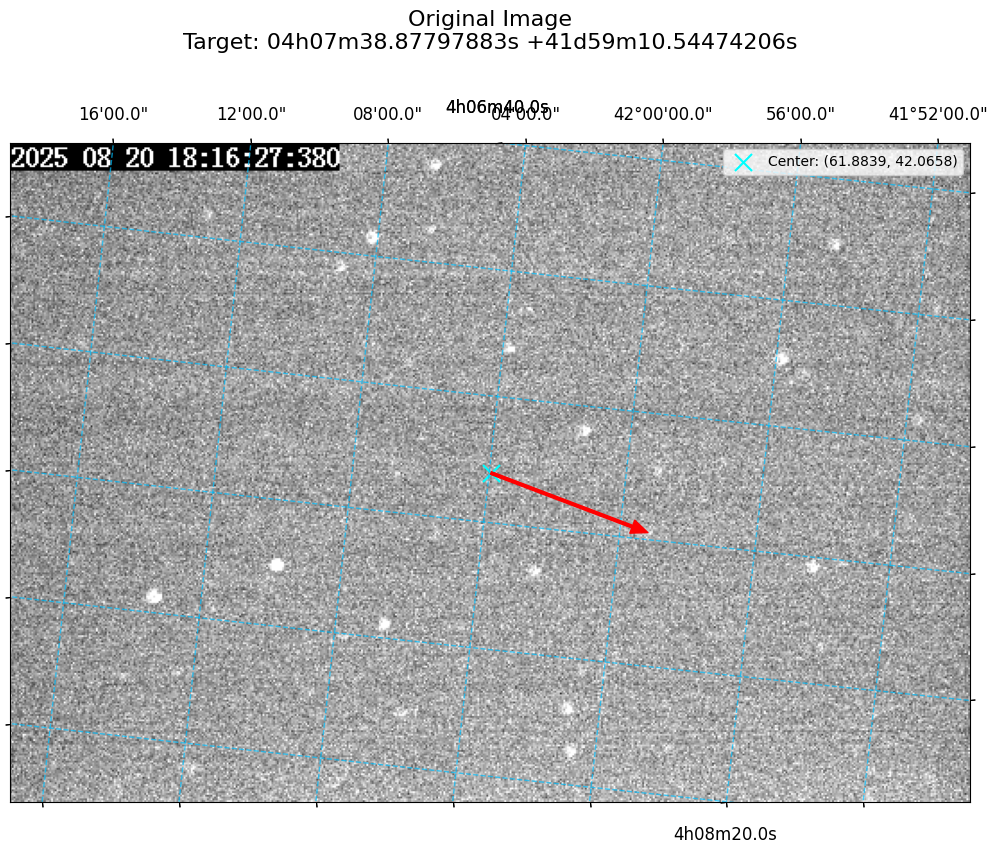


北を上にして回転させた画像をプロットします...
--- Field of View (視野角) ---
横      : 0.47° (28.2')
縦      : 0.32° (19.4')



-> 再投影画像: 目標座標は画像の範囲内です。

✅ 画像中心から目標までの角距離: 4.935 分角
   - 赤経(RA) 方向の差: 1.251 分角 (東へ)
   - 赤緯(Dec)方向の差: 4.774 分角 (南へ)


/Users/yoshi/.pyenv/versions/3.13.7/lib/python3.13/site-packages/astropy/visualization/wcsaxes/core.py:591: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/Users/yoshi/.pyenv/versions/3.13.7/lib/python3.13/site-packages/astropy/visualization/wcsaxes/core.py:591: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/Users/yoshi/.pyenv/versions/3.13.7/lib/python3.13/site-packages/astropy/visualization/wcsaxes/core.py:591: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/Users/yoshi/.pyenv/versions/3.13.7/lib/python3.13/site-packages/astropy/visualization/wcsaxes/core.py:591: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/Users/yoshi/.pyenv/versions/3.13.7/lib/python3.13/site-packages/astropy/visualization/wcsaxes/core.

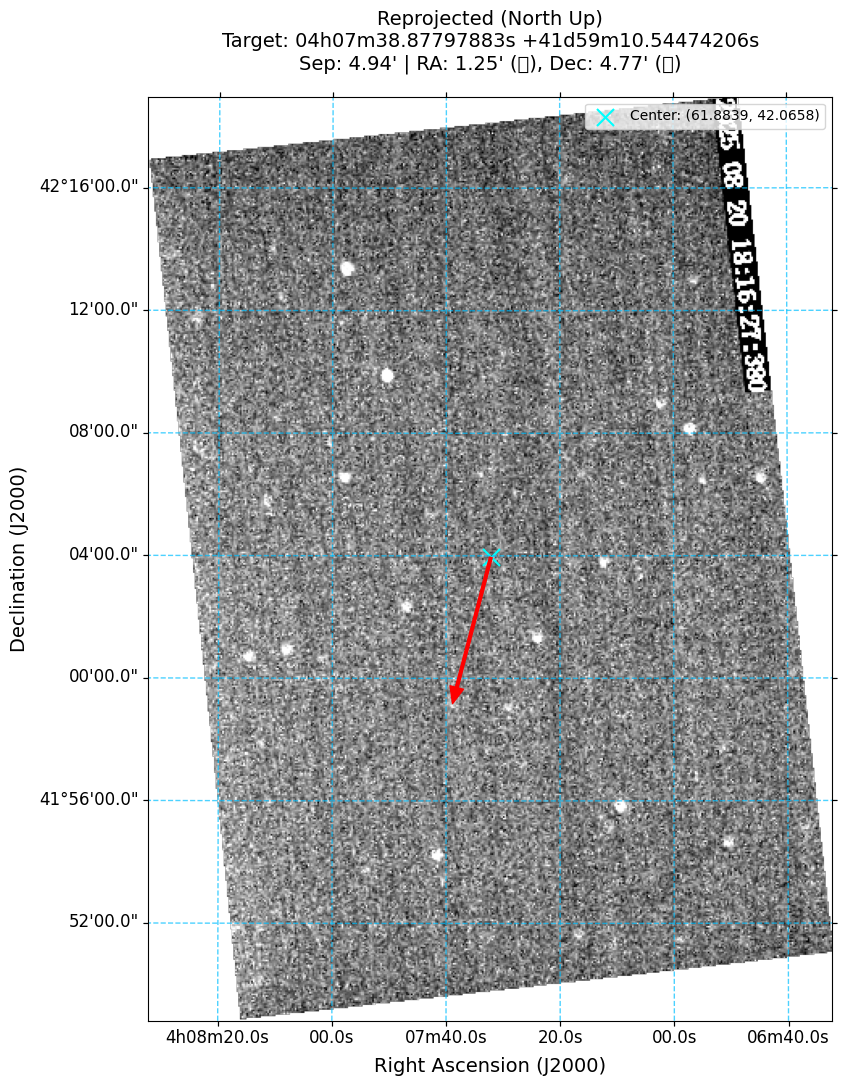

In [5]:
# ==============================================================================
# --- ユーザー設定項目 ---
# ==============================================================================
# 2. 目標の指定方法を選択 ('COORDS' または 'STAR_NAME')
INPUT_MODE = 'STAR_NAME'

# 3a. 座標で指定する場合 (INPUT_MODE = 'COORDS')
RA_INPUT_STR = "04h 07m 38.877s"
DEC_INPUT_STR = "+41d 59m 10.512s"

# 3b. 恒星名で指定する場合 (INPUT_MODE = 'STAR_NAME')
# カタログ名(TYC, UCAC4など)や一般的な名称(Polarisなど)が使用可能
TARGET_STAR_NAME = 'UCAC4 660-021020'
# ==============================================================================

API_KEY = "axvhxwfkvnzreobn"


def get_coords_from_simbad(star_name):
    """SIMBADを使って恒星名から座標を取得し、可能であればGaia DR3の高精度座標を返します。"""
    print(f"\nSIMBADで '{star_name}' の座標を検索しています...")
    try:
        # Step 1: SkyCoord.from_name()を使ってSIMBADから座標を直接取得
        simbad_coord = SkyCoord.from_name(star_name)
        print(f"-> SIMBADでの座標を特定: {simbad_coord.to_string('hmsdms')}")

        # Step 2: SIMBADの座標を元にGaia DR3を検索 (クロス（相互）マッチング)
        print("-> Gaia DR3カタログとクロス（相互）マッチング中...")
        v_gaia = Vizier(catalog="I/355/gaiadr3", columns=['RA_ICRS', 'DE_ICRS'])
        gaia_result = v_gaia.query_region(simbad_coord, radius=5 * u.arcsec)
        
        if not gaia_result or len(gaia_result) == 0:
            print(f"⚠️  近くにGaia DR3の天体が見つかりませんでした。SIMBADの座標を使用します。")
            return simbad_coord.ra.deg, simbad_coord.dec.deg

        gaia_star_data = gaia_result[0][0]
        ra_deg = gaia_star_data['RA_ICRS']
        dec_deg = gaia_star_data['DE_ICRS']
        
        print(f"✅ Gaia DR3の高精度座標が見つかりました: RA={ra_deg:.6f}°, Dec={dec_deg:.6f}°")
        return ra_deg, dec_deg

    except Exception as e:
        print(f"❌ エラー: '{star_name}'の座標検索中に問題が発生しました: {e}")
        return None, None


def parse_ra_dec_input(ra_input, dec_input):
    """RA/Dec を h m s / d m s 形式から度単位に変換します。"""
    coord = SkyCoord(ra_input, dec_input, frame='icrs')
    return coord.ra.deg, coord.dec.deg


def clip_arrow_to_boundary(start_x, start_y, end_x, end_y, x_lim, y_lim):
    """矢印の先端が画像の範囲外にある場合、画像の境界線までで切るように座標を計算します。"""
    xmin, xmax = min(x_lim), max(x_lim)
    ymin, ymax = min(y_lim), max(y_lim)

    if xmin <= end_x <= xmax and ymin <= end_y <= ymax:
        return end_x, end_y

    dx = end_x - start_x
    dy = end_y - start_y

    if dx == 0 and dy == 0:
        return end_x, end_y

    t_values = []
    if abs(dx) > 1e-9:
        t_values.append((xmin - start_x) / dx)
        t_values.append((xmax - start_x) / dx)
    if abs(dy) > 1e-9:
        t_values.append((ymin - start_y) / dy)
        t_values.append((ymax - start_y) / dy)

    min_t = float('inf')
    for t in t_values:
        if t > 1e-9:
            ix = start_x + t * dx
            iy = start_y + t * dy
            if (xmin - 1e-6) <= ix <= (xmax + 1e-6) and \
               (ymin - 1e-6) <= iy <= (ymax + 1e-6):
                if t < min_t:
                    min_t = t
    
    if min_t != float('inf'):
        min_t *= 0.99
        return start_x + min_t * dx, start_y + min_t * dy
    else:
        return end_x, end_y


def plot_original_image(wcs_header, data, ra_target, dec_target):
    """元の回転した画像をプロットします。"""
    print("\n元の画像をプロットします...")
    
    if 'SIMPLE' not in wcs_header:
        wcs_header['SIMPLE'] = True
    
    wcs = WCS(wcs_header)
    ny, nx = data.shape
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection=wcs)
    
    vmin, vmax = np.nanpercentile(data, 1), np.nanpercentile(data, 99)
    ax.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    
    ax.set_xlim(-0.5, nx - 0.5)
    ax.set_ylim(-0.5, ny - 0.5)
    ax.invert_yaxis()
    
    ra_axis, dec_axis = ax.coords[0], ax.coords[1]
    axis_color, grid_color = 'black', 'deepskyblue'
    ra_axis.set_axislabel('')
    dec_axis.set_axislabel('')
    ra_axis.set_ticklabel_position('bottom')
    dec_axis.set_ticklabel_position('left')
    ra_axis.set_ticklabel_visible(True)
    dec_axis.set_ticklabel_visible(True)
    ra_axis.set_major_formatter('hh:mm:ss.s')
    dec_axis.set_major_formatter('dd:mm:ss.s')
    ra_axis.set_separator(('h', 'm', 's'))
    dec_axis.set_separator(('°', "'", '"'))
    ra_axis.set_ticklabel(color=axis_color, size=12, rotation=0)
    dec_axis.set_ticklabel(color=axis_color, size=12)
    ax.tick_params(axis='x', pad=15)
    ax.tick_params(axis='y', pad=10)
    ra_axis.set_ticks(spacing=5 * u.arcmin, color=axis_color)
    dec_axis.set_ticks(spacing=4 * u.arcmin, color=axis_color)
    
    ax.coords.frame.set_color(axis_color)
    ax.grid(color=grid_color, linestyle='--', linewidth=1.0, alpha=0.7)
    
    center_coord = wcs.pixel_to_world(nx / 2.0, ny / 2.0)
    target_coord = SkyCoord(ra=ra_target*u.deg, dec=dec_target*u.deg, frame='fk5')
    start_x, start_y = wcs.world_to_pixel_values(center_coord.ra.deg, center_coord.dec.deg)
    
    try:
        tx, ty = wcs.world_to_pixel_values(target_coord.ra.deg, target_coord.dec.deg)
        if not np.all(np.isfinite([tx, ty])):
            raise ValueError("WCS returned non-finite coordinates")
        
        if 0 <= tx < nx and 0 <= ty < ny:
            print("-> 元画像: 目標座標は画像の範囲内です。")
        else:
            print("-> 元画像: 目標座標は画像の範囲外です。")

    except Exception:
        print("-> 元画像: 目標座標は画像の範囲外です。")
        pa = center_coord.position_angle(target_coord)
        near_target_coord = center_coord.directional_offset_by(pa, 1 * u.arcsec)
        near_tx, near_ty = wcs.world_to_pixel_values(near_target_coord.ra.deg, near_target_coord.dec.deg)
        dx_vec = near_tx - start_x
        dy_vec = near_ty - start_y
        tx = start_x + dx_vec * 1e6
        ty = start_y + dy_vec * 1e6
        
    clipped_tx, clipped_ty = clip_arrow_to_boundary(
        start_x, start_y, tx, ty, ax.get_xlim(), ax.get_ylim()
    )

    ax.scatter(start_x, start_y, color='cyan', marker='x', s=150,
               label=f'Center: ({center_coord.ra.deg:.4f}, {center_coord.dec.deg:.4f})')
    ax.annotate('', xy=(clipped_tx, clipped_ty), xytext=(start_x, start_y),
                arrowprops=dict(facecolor='red', edgecolor='red', width=2, headwidth=10))
    
    ax.set_title(f'Original Image\nTarget: {target_coord.to_string("hmsdms")}', color='black', size=16, pad=20, y=1.1)
    ax.legend(loc='upper right')
    
    fig.subplots_adjust(left=0.15, bottom=0.25, right=0.95, top=0.9)
    plt.show()


def plot_reprojected_image_full(wcs_header, data, ra_target, dec_target):
    """画像を赤経・赤緯軸に沿って回転させ、欠けなく描画します。"""
    print("\n北を上にして回転させた画像をプロットします...")
    
    if 'SIMPLE' not in wcs_header:
        wcs_header['SIMPLE'] = True
    
    wcs = WCS(wcs_header)
    ny, nx = data.shape
    
    try:
        fov_x = wcs.pixel_to_world(0, ny/2).separation(wcs.pixel_to_world(nx, ny/2))
        fov_y = wcs.pixel_to_world(nx/2, 0).separation(wcs.pixel_to_world(nx/2, ny))
        print(f"--- Field of View (視野角) ---\n"
              f"横      : {fov_x.degree:.2f}° ({fov_x.arcmin:.1f}')\n"
              f"縦      : {fov_y.degree:.2f}° ({fov_y.arcmin:.1f}')\n")
    except Exception as e:
        print(f"視野角を計算できませんでした: {e}")

    wcs_no_rotation = WCS(naxis=2)
    center_coord = wcs.pixel_to_world(nx/2, ny/2)
    wcs_no_rotation.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg]
    wcs_no_rotation.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    
    try:
        pixel_scale = np.sqrt(np.abs(np.linalg.det(wcs.wcs.cd)))
    except (AttributeError, np.linalg.LinAlgError):
        pixel_scale = np.mean(np.abs(wcs.wcs.cdelt))
        
    wcs_no_rotation.wcs.cdelt = np.array([-pixel_scale, pixel_scale])
    
    corners_pix = np.array([[0, 0], [nx, 0], [0, ny], [nx, ny]])
    corners_world = wcs.pixel_to_world(corners_pix[:, 0], corners_pix[:, 1])
    wcs_no_rotation.wcs.crpix = [0, 0]
    corners_new_pix = wcs_no_rotation.world_to_pixel(corners_world)
    x_min, x_max = np.min(corners_new_pix[0]), np.max(corners_new_pix[0])
    y_min, y_max = np.min(corners_new_pix[1]), np.max(corners_new_pix[1])
    
    shape_out = (int(np.ceil(y_max - y_min)), int(np.ceil(x_max - x_min)))
    wcs_no_rotation.wcs.crpix = [-x_min, -y_min]
    
    data_reprojected, footprint = reproject_interp((data, wcs), wcs_no_rotation, shape_out=shape_out)
    ny_reproj, nx_reproj = data_reprojected.shape
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection=wcs_no_rotation)
    
    data_reprojected[footprint == 0] = np.nan
    ax.imshow(data_reprojected, origin='lower', cmap='gray',
              vmin=np.nanpercentile(data_reprojected, 1), vmax=np.nanpercentile(data_reprojected, 99))
    
    ra_axis, dec_axis = ax.coords[0], ax.coords[1]
    axis_color, grid_color = 'black', 'deepskyblue'
    ra_axis.set_axislabel('Right Ascension (J2000)', color=axis_color, size=14)
    dec_axis.set_axislabel('Declination (J2000)', color=axis_color, size=14)
    ra_axis.set_major_formatter('hh:mm:ss.s')
    dec_axis.set_major_formatter('dd:mm:ss.s')
    ra_axis.set_separator(('h', 'm', 's'))
    dec_axis.set_separator(('°', "'", '"'))
    ra_axis.set_ticklabel(color=axis_color, size=12)
    dec_axis.set_ticklabel(color=axis_color, size=12)
    ra_axis.set_ticks(spacing=5 * u.arcmin, color=axis_color)
    dec_axis.set_ticks(spacing=4 * u.arcmin, color=axis_color)
    
    ax.coords.frame.set_color(axis_color)
    ax.grid(color=grid_color, linestyle='--', linewidth=1.0, alpha=0.7)
    
    center_coord_original = wcs.pixel_to_world(nx / 2.0, ny / 2.0)
    target_coord = SkyCoord(ra=ra_target*u.deg, dec=dec_target*u.deg, frame='fk5')
    start_x, start_y = wcs_no_rotation.world_to_pixel_values(center_coord_original.ra.deg, center_coord_original.dec.deg)
    
    try:
        tx, ty = wcs_no_rotation.world_to_pixel_values(target_coord.ra.deg, target_coord.dec.deg)
        if not np.all(np.isfinite([tx, ty])):
            raise ValueError("WCS returned non-finite coordinates")
        
        if 0 <= tx < nx_reproj and 0 <= ty < ny_reproj:
            print("-> 再投影画像: 目標座標は画像の範囲内です。")
        else:
            print("-> 再投影画像: 目標座標は画像の範囲外です。")
        
    except Exception:
        print("-> 再投影画像: 目標座標は画像の範囲外です。")
        pa = center_coord_original.position_angle(target_coord)
        near_target_coord = center_coord_original.directional_offset_by(pa, 1 * u.arcsec)
        near_tx, near_ty = wcs_no_rotation.world_to_pixel_values(near_target_coord.ra.deg, near_target_coord.deg)
        dx_vec = near_tx - start_x
        dy_vec = near_ty - start_y
        tx = start_x + dx_vec * 1e6
        ty = start_y + dy_vec * 1e6

    # 1. 全体の角距離を計算
    separation = center_coord_original.separation(target_coord)
    separation_arcmin = separation.arcmin
    print(f"\n✅ 画像中心から目標までの角距離: {separation_arcmin:.3f} 分角")

    # 2. 赤経・赤緯方向の差（オフセット）を計算
    # .spherical_offsets_to() を使うと赤緯を考慮した正確なRA方向の角距離が求まる
    d_ra_cosdec, d_dec = center_coord_original.spherical_offsets_to(target_coord)

    # 3. 分角に変換
    d_ra_arcmin = d_ra_cosdec.to(u.arcmin).value
    d_dec_arcmin = d_dec.to(u.arcmin).value

    # 4. 方向を示す文字列を決定
    ra_direction = "東" if d_ra_arcmin > 0 else "西"
    dec_direction = "北" if d_dec_arcmin > 0 else "南"

    # 5. 結果を出力
    print(f"   - 赤経(RA) 方向の差: {abs(d_ra_arcmin):.3f} 分角 ({ra_direction}へ)")
    print(f"   - 赤緯(Dec)方向の差: {abs(d_dec_arcmin):.3f} 分角 ({dec_direction}へ)")
    
    clipped_tx, clipped_ty = clip_arrow_to_boundary(
        start_x, start_y, tx, ty, ax.get_xlim(), ax.get_ylim()
    )

    ax.scatter(start_x, start_y, color='cyan', marker='x', s=150,
               label=f'Center: ({center_coord_original.ra.deg:.4f}, {center_coord_original.dec.deg:.4f})')
    ax.annotate('', xy=(clipped_tx, clipped_ty), xytext=(start_x, start_y),
                arrowprops=dict(facecolor='red', edgecolor='red', width=2, headwidth=10))
    
    # グラフタイトルにも詳細な角距離情報を追加
    title_text = (f'Reprojected (North Up)\n'
                  f'Target: {target_coord.to_string("hmsdms")}\n'
                  f'Sep: {separation_arcmin:.2f}\' | RA: {abs(d_ra_arcmin):.2f}\' ({ra_direction}), Dec: {abs(d_dec_arcmin):.2f}\' ({dec_direction})')
    ax.set_title(title_text, color='black', size=14, pad=20)
    ax.legend(loc='upper right')
    
    plt.show()


if __name__ == '__main__':
    # このセルが直接実行された場合にのみ以下のコードを実行
    # (Jupyter NotebookやGoogle Colab環境での標準的な使い方)
    if 'uploader' in globals() and uploader.value:
        uploaded_file = uploader.value[0]
        file_content = uploaded_file['content']
        file_name = uploaded_file['name']
        
        # 一時ファイルを作成して画像データを保存
        with tempfile.NamedTemporaryFile(delete=False, suffix=os.path.splitext(file_name)[1]) as temp_file:
            temp_file.write(file_content)
            IMG_FILEPATH = temp_file.name
        
        print(f"\n✅ ファイル '{file_name}' が選択されました。パス: {IMG_FILEPATH}")

        if not os.path.exists(IMG_FILEPATH):
            print(f"❌ エラー: 指定された画像ファイルが見つかりません: {IMG_FILEPATH}")
        else:
            ra_target_deg, dec_target_deg = None, None
            
            if INPUT_MODE == 'STAR_NAME':
                if TARGET_STAR_NAME:
                    ra_target_deg, dec_target_deg = get_coords_from_simbad(TARGET_STAR_NAME)
                else:
                    print("エラー: INPUT_MODEが'STAR_NAME'ですが、TARGET_STAR_NAMEが設定されていません。")

            elif INPUT_MODE == 'COORDS':
                ra_target_deg, dec_target_deg = parse_ra_dec_input(RA_INPUT_STR, DEC_INPUT_STR)
            
            else:
                print(f"エラー: 無効なINPUT_MODEです: '{INPUT_MODE}'。'COORDS' または 'STAR_NAME' を使用してください。")

            if ra_target_deg is not None and dec_target_deg is not None:
                print(f"最終的な目標座標: RA={ra_target_deg:.6f}°, Dec={dec_target_deg:.6f}°")
                
                wcs_solution_header = None
                image_data = None

                # FITSファイルの場合の処理
                if IMG_FILEPATH.lower().endswith(('.fits', '.fit')):
                    print("FITSファイルを読み込み中...")
                    with fits.open(IMG_FILEPATH) as hdul:
                        image_data = hdul[0].data
                        try:
                            wcs = WCS(hdul[0].header)
                            if wcs.is_celestial:
                                print("✅ ファイルからWCS情報を読み込みました。Astrometry.netは使用しません。")
                                wcs_solution_header = hdul[0].header
                        except Exception as e:
                            print(f"ファイルに有効なWCS情報がありませんでした。Astrometry.netを試します。")

                # WCS情報がない場合（JPG/PNGまたはWCSなしFITS）
                if wcs_solution_header is None:
                    print("\nAstrometry.netを使用してWCS情報を取得します。")
                    if image_data is None: # JPG/PNGの場合、ここでデータをロード
                        with Image.open(IMG_FILEPATH) as img:
                            image_data = np.array(img.convert('L'))
                    
                    try:
                        print("Astrometry.netに接続中...")
                        ast = AstrometryNet()
                        ast.api_key = API_KEY
                        wcs_solution_header = ast.solve_from_image(IMG_FILEPATH, solve_timeout=300)
                    except Exception as e:
                        print(f"❌ エラー: Astrometry.netへの接続に失敗しました: {e}")
                        print("しばらく待ってから再試行するか、ネットワーク接続やAPIキーを確認してください。")

                if wcs_solution_header:
                    plot_original_image(wcs_solution_header, image_data, ra_target_deg, dec_target_deg)
                    plot_reprojected_image_full(wcs_solution_header, image_data, ra_target_deg, dec_target_deg)
                else:
                    print("\nWCS情報を取得できなかったため、プロットを実行できませんでした。")
            else:
                print("\n目標座標を取得できなかったため、プロットを中止しました。")
    else:
        print("\n⚠️ 画像ファイルが選択されていません。セル1に戻ってファイルを選択してから、このセルを再実行してください。")